## Import-import

In [191]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

# Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout, GRU
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [148]:
train = pd.read_csv("train.csv")
train.shape

(13258, 16)

In [149]:
train_hourly = pd.read_csv("train_hourly.csv")
train_hourly.shape

(318192, 32)

In [150]:
test = pd.read_csv("test.csv")
test.shape

(4972, 16)

In [151]:
test_hourly = pd.read_csv("test_hourly.csv")
test_hourly.shape

(119328, 32)

In [152]:
city_dic = {'su' : '1', 'si' : '2', 'u' : '3', 'le' : '4', 'p' : '5', 'lh' : '6', 'b' : '7', 't' : '8', 'sa' : '9', 'q' : '10'}

# EDA

Pada train hourly, terdapat 170 baris yang berisi nilai null semua, maka dari itu baris-baris tsb akan didrop

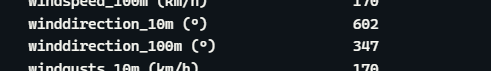

Kecuali untuk kedua kolom tersebut, akan diisi nilai rata2 berdasarkan tahun dan city-nya

In [153]:
def clean_train_hourly(df) :
    # df['city'] = df['city'].map(city_dic)
    df.insert(1, 'date', df['time'].str[:10])
    df.insert(2, 'hour', df['time'].str[11:13])
    df['hour'] = df['hour'].astype('int')

    # Kolom year hanya diperlukan untuk handle missing value
    df['year'] = pd.to_datetime(df['date']).dt.year
    df.drop('time', axis=1, inplace=True)

    df['winddirection_10m (°)'] = df['winddirection_10m (°)'].fillna(df.groupby(['city', 'year'])['winddirection_10m (°)'].transform('median'))
    df['winddirection_100m (°)'] = df['winddirection_100m (°)'].fillna(df.groupby(['city', 'year'])['winddirection_100m (°)'].transform('median'))
    df.drop('year', axis=1, inplace=True)

Selain kedua kolom itu, data akan didrop karena memang baris-barisnya kosonggg (data tahun 2022)

In [154]:
clean_train_hourly(train_hourly)
train_hourly = train_hourly.dropna()
train_hourly.head(1)

,date,hour,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,2018-01-01,0,25.0,94.0,24.1,32.3,1007.0,1009.3,0.0,82.0,...,0.18,26.8,28.5,28.7,29.3,0.298,0.307,0.281,0.28,su


In [155]:
def clean_test_hourly(df) :
    # df['city'] = df['city'].map(city_dic)
    df.insert(1, 'date', df['time'].str[:10])
    df.insert(2, 'hour', df['time'].str[11:13])
    df['hour'] = df['hour'].astype('int')
    df.drop('time', axis=1, inplace=True)

In [156]:
clean_test_hourly(test_hourly)
test_hourly = test_hourly.dropna()
test_hourly.head(1)

,date,hour,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,2021-08-02,0,26.1,73.0,21.0,31.0,1010.9,1013.2,0.0,5.0,...,0.9,27.4,30.7,29.2,28.6,0.056,0.078,0.113,0.234,su


In [157]:
train.rename(columns={'time': 'date'}, inplace=True)
# train['city'] = train['city'].map(city_dic)

In [158]:
train_hourly_agg = train_hourly.groupby(['date', 'city']).agg('mean').reset_index()
train_hourly_agg = train_hourly_agg.drop('hour', axis=1)
train_hourly_agg.head(1)

,date,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,b,17.825,98.708333,17.5875,21.05,1011.916667,878.941667,0.0,92.125,...,0.046667,0.029583,18.6375,18.925,19.479167,19.8875,0.4255,0.426708,0.399458,0.432042


In [159]:
test.rename(columns={'time': 'date'}, inplace=True)
# test['city'] = test['city'].map(city_dic)
test.drop('id', axis=1, inplace=True)

In [160]:
test_hourly_agg = test_hourly.groupby(['date', 'city']).agg('mean').reset_index()
test_hourly_agg = test_hourly_agg.drop('hour', axis=1)
test_hourly_agg.head(1)


,date,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,b,19.758333,84.75,16.983333,21.091667,1014.216667,881.316667,0.0,59.541667,...,0.135417,0.387917,20.608333,20.4875,20.4,20.2,0.355375,0.327583,0.336417,0.409958


In [161]:
train['is_snowing'] = train['snowfall_sum (cm)'].apply(lambda x: 1 if x > 0 else 0)
train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,6.9,20.2,277.0,3.61,0,su,0


In [162]:
test['is_snowing'] = test['snowfall_sum (cm)'].apply(lambda x: 1 if x > 0 else 0)
test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,16.9,134.0,4.45,0,su,0


In [163]:
merged_train = pd.merge(train, train_hourly_agg,
                        how='outer', on=['date', 'city'])

# Handling missing values on train data
merged_train['year'] = pd.to_datetime(merged_train['date']).dt.year
merged_train['winddirection_10m_dominant (°)'] = merged_train['winddirection_10m_dominant (°)'].fillna(merged_train.groupby(['city', 'year'])['winddirection_10m_dominant (°)'].transform('median'))
merged_train = merged_train.dropna()
# merged_train.insert(1, 'day_month', merged_train['date'].str[5:10])
# merged_train = merged_train.drop('date', axis=1)
merged_train = merged_train.drop('year', axis=1)

merged_train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,...,0.150417,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28


In [164]:
merged_test = pd.merge(test, test_hourly_agg, how='outer', on=['date', 'city'])
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [165]:
# merged_test.insert(1, 'day_month', merged_test['date'].str[5:10])
# merged_test = merged_test.drop('date', axis=1)
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [166]:
def sincostime(df):
    date_time = pd.to_datetime(df['date'])
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24*60*60
    year= (365.2425)*day

    df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [167]:
def sunrise_sunset(df) :
    # Pisah jam dan menit
    df.insert(4, 'sunrise (hour)', df['sunrise (iso8601)'].str[11:13])
    df['sunrise (hour)'] = df['sunrise (hour)'].astype('int')

    df.insert(5, 'sunrise (minute)', df['sunrise (iso8601)'].str[14:])
    df['sunrise (minute)'] = df['sunrise (minute)'].astype('int')

    df.insert(6, 'sunset (hour)', df['sunset (iso8601)'].str[11:13])
    df['sunset (hour)'] = df['sunset (hour)'].astype('int')

    df.insert(7, 'sunset (minute)', df['sunset (iso8601)'].str[14:])
    df['sunset (minute)'] = df['sunset (minute)'].astype('int')

    # Drop kolom awal
    df.drop(['sunrise (iso8601)', 'sunset (iso8601)'], axis=1, inplace=True)

    # Get selisih sunrise-sunset
    df['sunrise_time'] = df['sunrise (hour)'].astype(str) + ':' + df['sunrise (minute)'].astype(str)
    df['sunset_time'] = df['sunset (hour)'].astype(str) + ':' + df['sunset (minute)'].astype(str)

    df['sunrise_time'] = pd.to_datetime(df['sunrise_time'], format='%H:%M')
    df['sunset_time'] = pd.to_datetime(df['sunset_time'], format='%H:%M')

    df['sunrise_to_sunset'] = (df['sunset_time'] - df['sunrise_time']).dt.total_seconds() / 3600

    df = df.drop(['sunrise (hour)', 'sunrise (minute)', 'sunset (hour)','sunset (minute)', 'sunrise_time', 'sunset_time'], axis=1, inplace=True)

In [168]:
sunrise_sunset(merged_train)
merged_train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,2018-01-01,29.9,26.0,36.3,31.6,17.59,7.7,0.0,6.9,20.2,...,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28,12.566667


In [169]:
sunrise_sunset(merged_test)
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,2021-08-02,32.3,25.3,38.2,29.6,20.79,0.0,7.6,16.9,134.0,...,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234,11.85


In [170]:
sincostime(merged_train)
sincostime(merged_test)

In [171]:
# Memisahkan data yang tidak di-scale
keep = merged_train[['date', 'city', 'is_snowing', 'rain_sum (mm)']]
merged_train = merged_train.drop(['date', 'city', 'is_snowing',  'rain_sum (mm)'], axis=1)

In [172]:
train_stand = StandardScaler()
train_normal = MinMaxScaler()
train_robust = RobustScaler()

fit_train_robust = train_robust.fit_transform(merged_train)
train_robust = pd.DataFrame(columns=merged_train.columns, index=merged_train.index, data=fit_train_robust)

fit_train_std = train_stand.fit_transform(train_robust)
train_std = pd.DataFrame(columns=train_robust.columns, index=train_robust.index, data=fit_train_std)

fit_train_normal = train_normal.fit_transform(train_std)
train_normal = pd.DataFrame(columns=train_std.columns, index=train_std.index, data=fit_train_normal)
train_normal.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,day_sin,day_cos,year_sin,year_cos
0,0.869376,0.959612,0.877778,0.96011,0.542566,0.0,0.072027,0.109477,0.769444,0.473753,...,0.957341,0.644171,0.632397,0.585039,0.534251,0.925573,0.755222,0.0,0.503096,0.999991


In [173]:
train_scaled = pd.concat([train_normal, keep], axis=1)
train_scaled.head(1)


,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,day_sin,day_cos,year_sin,year_cos,date,city,is_snowing,rain_sum (mm)
0,0.869376,0.959612,0.877778,0.96011,0.542566,0.0,0.072027,0.109477,0.769444,0.473753,...,0.534251,0.925573,0.755222,0.0,0.503096,0.999991,2018-01-01,su,0,7.7


In [174]:
# Memisahkan data yang tidak di-scale
keep = merged_test[['date', 'city', 'is_snowing']]
merged_test = merged_test.drop(
    ['date', 'city', 'is_snowing'], axis=1)


In [175]:
test_stand = StandardScaler()
test_normal = MinMaxScaler()
test_robust = RobustScaler()

fit_test_robust = test_robust.fit_transform(merged_test)
test_robust = pd.DataFrame(columns=merged_test.columns, index=merged_test.index, data=fit_test_robust)

fit_test_std = test_stand.fit_transform(test_robust)
test_std = pd.DataFrame(columns=test_robust.columns, index=test_robust.index, data=fit_test_std)

fit_test_normal = test_normal.fit_transform(test_std)
test_normal = pd.DataFrame(columns=test_std.columns, index=test_std.index, data=fit_test_normal)
test_normal.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,day_sin,day_cos,year_sin,year_cos
0,0.931638,0.956835,0.921438,0.939079,0.642857,0.0,0.097701,0.140715,0.372222,0.706349,...,0.969365,0.085616,0.073812,0.124869,0.399779,0.90537,0.455206,0.0,0.245729,0.069476


In [176]:
test_scaled = pd.concat([test_normal, keep], axis=1)
test_scaled.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,day_sin,day_cos,year_sin,year_cos,date,city,is_snowing
0,0.931638,0.956835,0.921438,0.939079,0.642857,0.0,0.097701,0.140715,0.372222,0.706349,...,0.124869,0.399779,0.90537,0.455206,0.0,0.245729,0.069476,2021-08-02,su,0


# Feature Selection

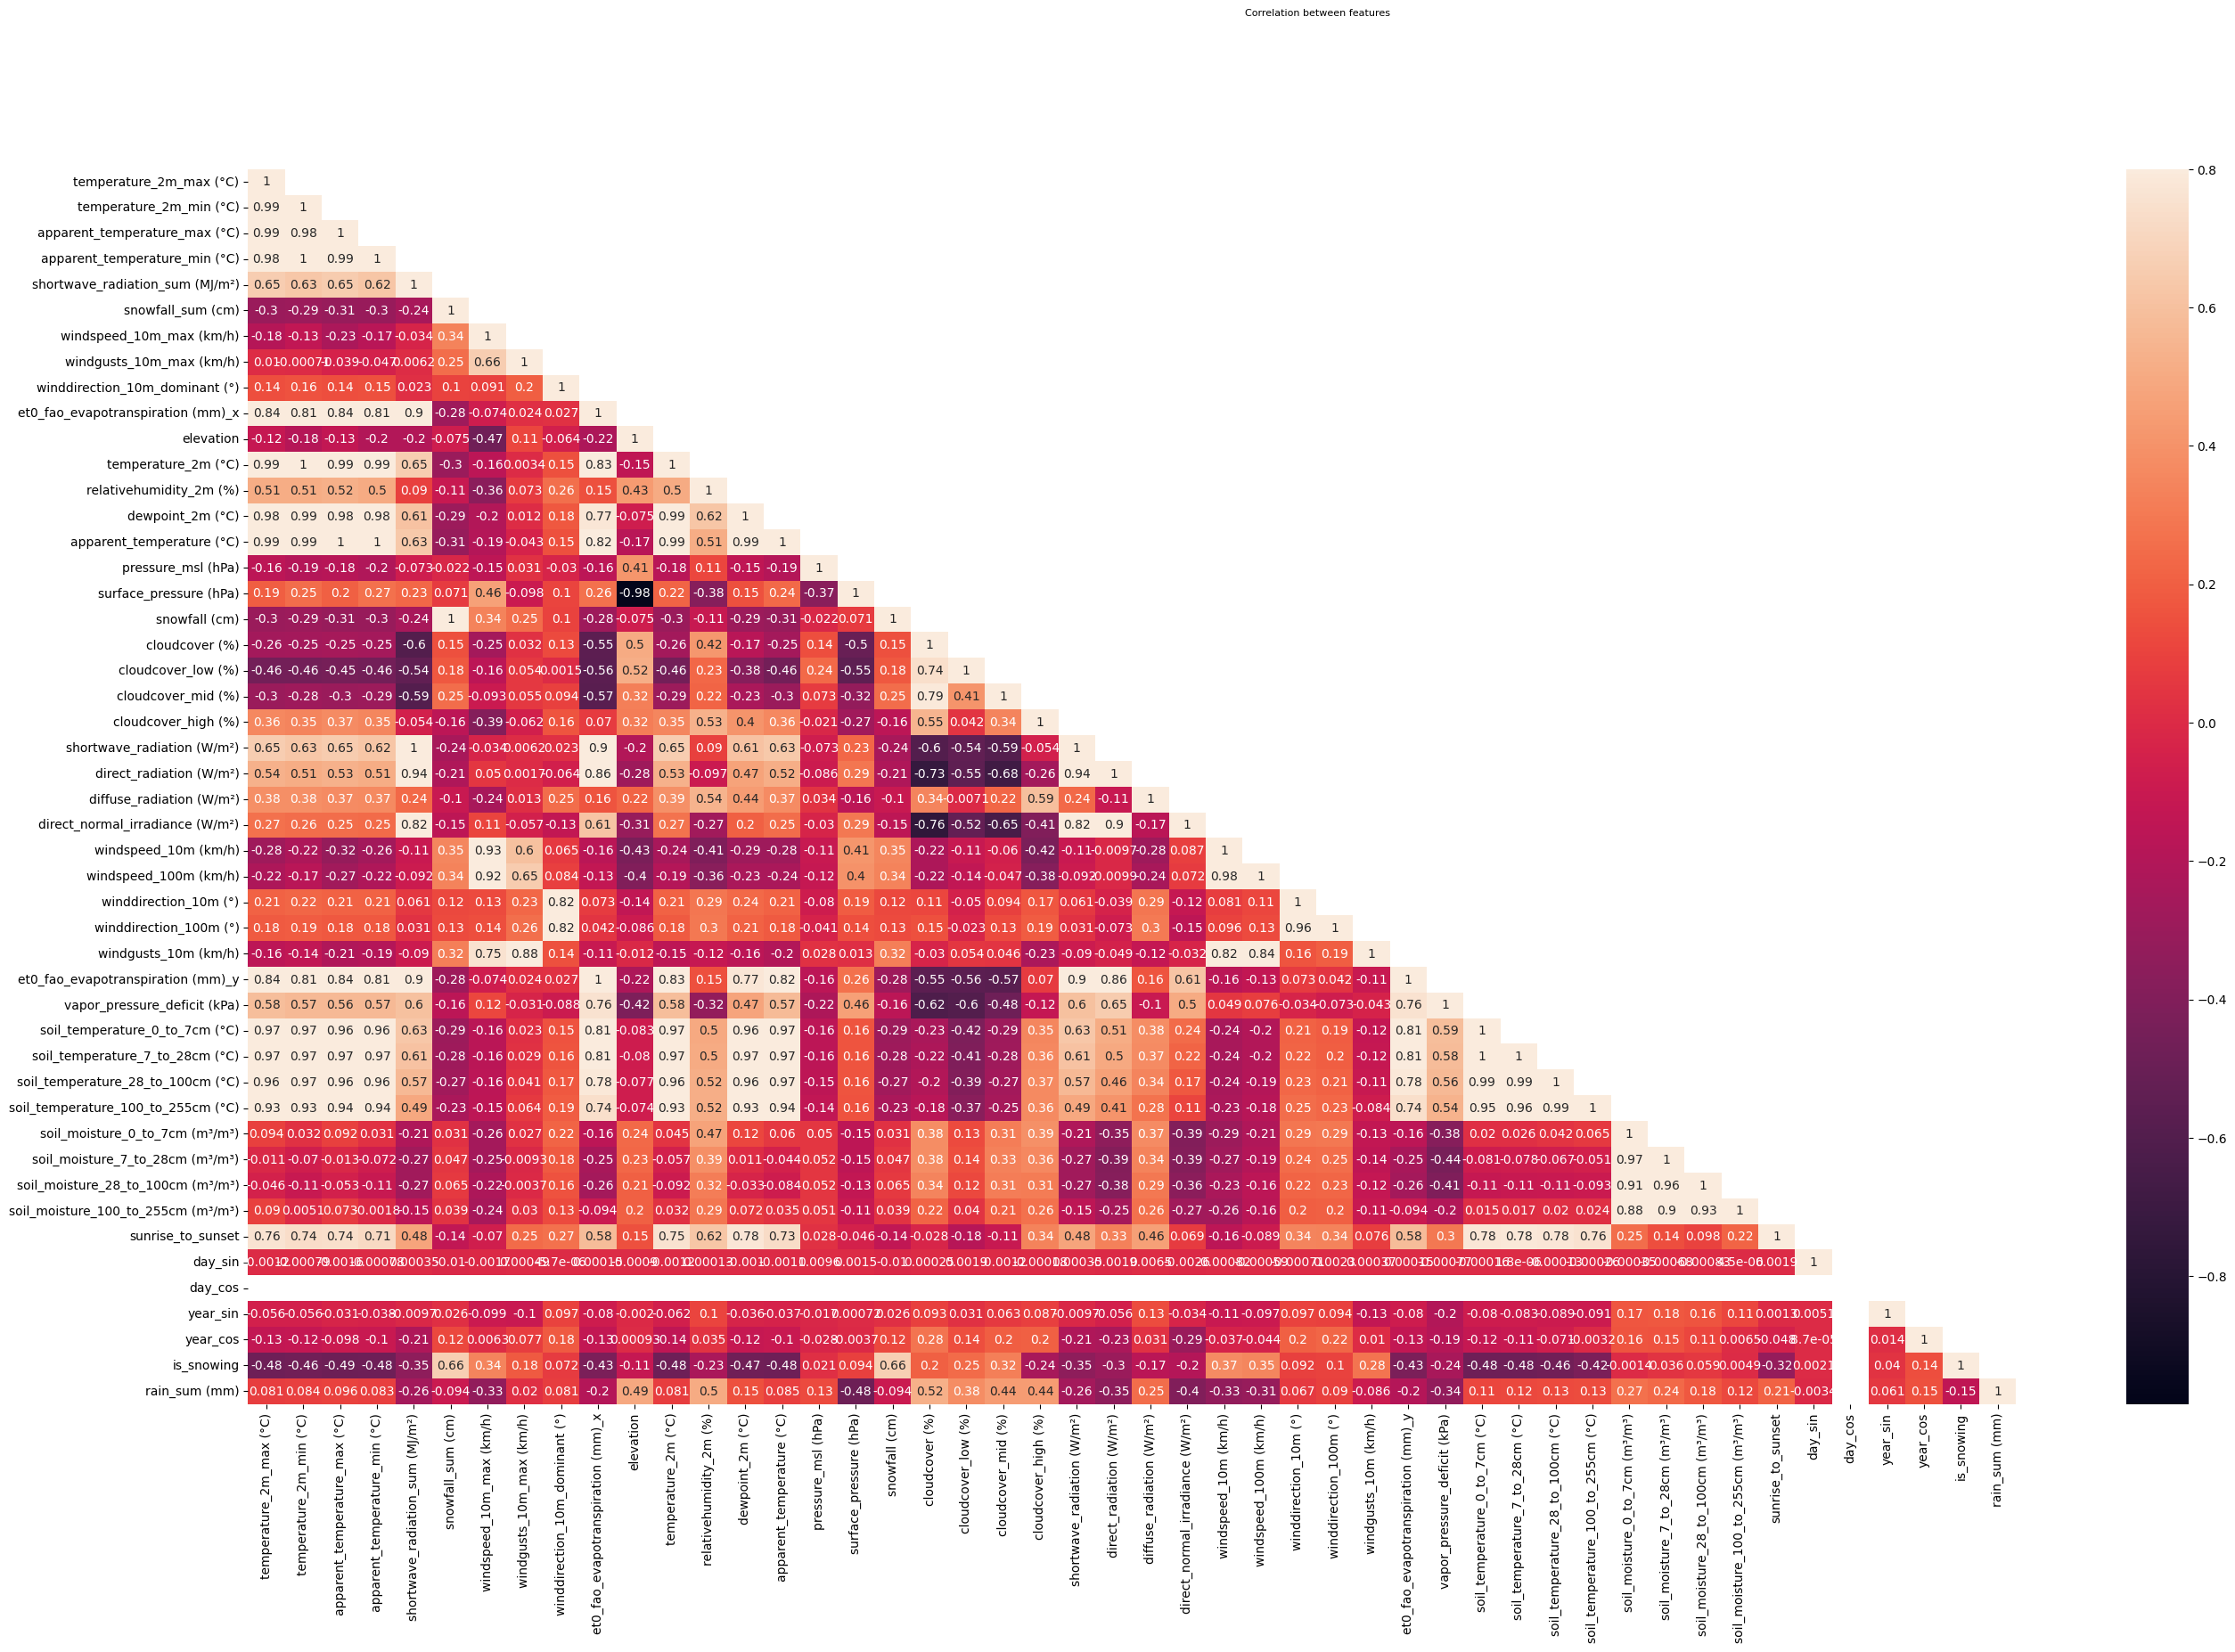

In [177]:
corrcoef = train_scaled.corr()

fig,ax = plt.subplots(figsize=(32,18)) 
fig.suptitle("Correlation between features", fontsize=8)
mask = np.array(corrcoef)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
plt.show()

In [178]:
highest_corr = corrcoef['rain_sum (mm)'].abs().sort_values(ascending=False)
highest_corr = highest_corr.keys().tolist()

In [182]:
top = highest_corr[0:21]
top

['rain_sum (mm)',
 'cloudcover (%)',
 'relativehumidity_2m (%)',
 'elevation',
 'surface_pressure (hPa)',
 'cloudcover_mid (%)',
 'cloudcover_high (%)',
 'direct_normal_irradiance (W/m²)',
 'cloudcover_low (%)',
 'direct_radiation (W/m²)',
 'vapor_pressure_deficit (kPa)',
 'windspeed_10m (km/h)',
 'windspeed_10m_max (km/h)',
 'windspeed_100m (km/h)',
 'soil_moisture_0_to_7cm (m³/m³)',
 'shortwave_radiation (W/m²)',
 'shortwave_radiation_sum (MJ/m²)',
 'diffuse_radiation (W/m²)',
 'soil_moisture_7_to_28cm (m³/m³)',
 'sunrise_to_sunset',
 'et0_fao_evapotranspiration (mm)_y']

In [183]:
top.append('is_snowing')
top.append('city')

train_final = train_scaled[top]
train_final.insert(0, 'date', train_scaled['date'])
train_final.head(1)

,date,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),...,windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing,city
0,2018-01-01,7.7,0.730417,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,0.319631,...,0.038542,0.644171,0.542527,0.542566,0.519873,0.632397,0.925573,0.473753,0,su


In [184]:
one = OneHotEncoder()
one_hot_train = pd.DataFrame(one.fit_transform(train_final[['city']]).toarray())
train_final = train_final.join(one_hot_train)
train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,6.9,20.2,277.0,3.61,0,su,0


In [185]:
top_test = top.copy()
top_test.remove('rain_sum (mm)')
test_final = test_scaled[top_test]
test_final.insert(0, 'date', test_scaled['date'])
test_final.head(1)

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing,city
0,2021-08-02,0.13625,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,...,0.089102,0.085616,0.642953,0.642857,0.235847,0.073812,0.90537,0.706349,0,su


In [186]:
one = OneHotEncoder()
one_hot_test = pd.DataFrame(one.fit_transform(test_final[['city']]).toarray())
test_final = test_final.join(one_hot_test)
test_final.head(1)

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,0,1,2,3,4,5,6,7,8,9
0,2021-08-02,0.13625,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [187]:
train_final = train_final.drop('city', axis=1)
test_final = test_final.drop('city', axis=1)

In [52]:
# train_scaled.to_csv('full_train_final.csv')
# test_scaled.to_csv('full_test_final.csv')

In [53]:
# train_final.to_csv('20_train_final.csv')
# test_final.to_csv('20_test_final.csv')

# Model

In [188]:
train_final = train_final.set_index('date')
train_final.head(1)

,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,7.7,0.730417,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,0.319631,0.339211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [189]:
test_final = test_final.set_index('date')
test_final.head(1)

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,,,,,,,,,,,,
2021-08-02,0.13625,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,0.716211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [201]:
X = train_final.drop('rain_sum (mm)', axis=1)
y = train_final['rain_sum (mm)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

X_train = X_train.to_numpy().reshape((X_train.shape[0],  X_train.shape[1], 1))
X_test = X_test.to_numpy().reshape((X_test.shape[0],  X_test.shape[1], 1))

In [203]:
X_train

array([[[0.8075    ],
        [0.44379467],
        [0.00634802],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.5325    ],
        [0.77777778],
        [0.        ],
        ...,
        [1.        ],
        [0.        ],
        [0.        ]],

       [[0.60791667],
        [0.82131254],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.91708333],
        [0.88369071],
        [0.51941748],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.53833333],
        [0.85120208],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.08875   ],
        [0.61403509],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [205]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs=300, batch_size=32)
test = test_final.to_numpy().reshape((test_final.shape[0],  test_final.shape[1], 1))
predictions = model.predict(test)
predictions2 = predictions.reshape((predictions.shape[0],))
result = pd.DataFrame({'rain_sum (mm)' : predictions2})
print('Max:', result['rain_sum (mm)'].max())
print('Mean:', result['rain_sum (mm)'].mean())

Epoch 1/300
303/369 [=======================>......] - ETA: 1s - loss: nan

KeyboardInterrupt: 

In [194]:
# The LSTM architecture
model = Sequential()
# First, LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))

# Second, GRU layer
model.add(GRU(units=50, return_sequences=False, activation='relu'))
# model.add(Dropout(0.2))

# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
369/369 [==============================] - 19s 28ms/step - loss: nan
Epoch 2/10
369/369 [==============================] - 10s 27ms/step - loss: nan
Epoch 3/10
369/369 [==============================] - 9s 26ms/step - loss: nan
Epoch 4/10
369/369 [==============================] - 10s 28ms/step - loss: nan
Epoch 5/10
369/369 [==============================] - 11s 31ms/step - loss: nan
Epoch 6/10
171/369 [============>.................] - ETA: 7s - loss: nan

KeyboardInterrupt: 

In [ ]:

model = Sequential()

model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train[1], X_train[2]))))
model.add(GRU(units=64, return_sequences=False, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['acc'])
model.fit(X_train,y_train,epochs=100, verbose=1, validation_data=(X_test, y_test), batch_size=50)

In [101]:
train_final.head(1)

,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,dewpoint_2m (°C),is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm)
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,7.7,0.730417,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,0.319631,0.339211,...,0.96218,0,0.957341,0.397753,0.929825,0.534251,0.905715,0.893182,0.877778,0.0


In [102]:
test_final.head(1)

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,dewpoint_2m (°C),is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm)
date,,,,,,,,,,,,,,,,,,,,,
2021-08-02,0.13625,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,0.716211,...,0.899366,0,0.969365,0.577482,0.962571,0.399779,0.960003,0.96043,0.921438,0.0


In [103]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=300, batch_size=32)
test = test_final.to_numpy().reshape((test_final.shape[0],  test_final.shape[1], 1))
predictions = model.predict(test)
predictions2 = predictions.reshape((predictions.shape[0],))
result = pd.DataFrame({'rain_sum (mm)' : predictions2})
print('Max:', result['rain_sum (mm)'].max())
print('Mean:', result['rain_sum (mm)'].mean())

Epoch 1/300
369/369 [==============================] - 5s 11ms/step - loss: 92.0379
Epoch 2/300
369/369 [==============================] - 4s 11ms/step - loss: 60.0693
Epoch 3/300
369/369 [==============================] - 5s 14ms/step - loss: 52.2367
Epoch 4/300
369/369 [==============================] - 5s 15ms/step - loss: 50.5429
Epoch 5/300
369/369 [==============================] - 6s 16ms/step - loss: 48.7854
Epoch 6/300
369/369 [==============================] - 6s 15ms/step - loss: 48.1329
Epoch 7/300
369/369 [==============================] - 6s 15ms/step - loss: 48.4413
Epoch 8/300
369/369 [==============================] - 6s 16ms/step - loss: 48.1355
Epoch 9/300
369/369 [==============================] - 6s 16ms/step - loss: 47.0912
Epoch 10/300
369/369 [==============================] - 5s 14ms/step - loss: 47.6196
Epoch 11/300
369/369 [==============================] - 5s 14ms/step - loss: 47.3596
Epoch 12/300
369/369 [==============================] - 5s 15ms/step - los

In [61]:
# Define the model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Use the model to make predictions on new data
y_pred = model.predict(X_test)

Epoch 1/100
369/369 [==============================] - 13s 30ms/step - loss: 108.5283
Epoch 2/100
369/369 [==============================] - 13s 34ms/step - loss: 114.4466
Epoch 3/100
369/369 [==============================] - 12s 32ms/step - loss: 83.3202
Epoch 4/100
369/369 [==============================] - 13s 35ms/step - loss: 92.2530
Epoch 5/100
369/369 [==============================] - 10s 27ms/step - loss: 56.8487
Epoch 6/100
369/369 [==============================] - 13s 34ms/step - loss: 53.8039
Epoch 7/100
369/369 [==============================] - 9s 26ms/step - loss: 49.9323
Epoch 8/100
369/369 [==============================] - 11s 30ms/step - loss: 48.9210
Epoch 9/100
369/369 [==============================] - 14s 37ms/step - loss: 48.7018
Epoch 10/100
369/369 [==============================] - 12s 32ms/step - loss: 48.6365
Epoch 11/100
369/369 [==============================] - 12s 33ms/step - loss: 48.0001
Epoch 12/100
369/369 [==============================] - 12s 31

In [62]:
test = test_final.to_numpy().reshape((test_final.shape[0],  test_final.shape[1], 1))
predictions = model.predict(test)

156/156 [==============================] - 1s 5ms/step


In [63]:
predictions.shape

(4972, 1)

In [64]:
predictions2 = predictions.reshape((predictions.shape[0],))

In [105]:
result = pd.DataFrame({'rain_sum (mm)' : predictions2})

In [106]:
result

,rain_sum (mm)
0,0.107931
1,0.293261
2,0.219086
3,0.274422
4,0.386049
...,...
4967,-0.110614
4968,0.478086
4969,-0.021070
4970,-0.064545


In [107]:
result['rain_sum (mm)'] = result['rain_sum (mm)'].apply(lambda x: 0 if x < 0 else x)

In [86]:
result[result['rain_sum (mm)'] < 0]

,rain_sum (mm)


In [117]:
result['rain_sum (mm)'].mean()

5.686212496827517

In [118]:
result['rain_sum (mm)'].max()

96.85980987548828

In [88]:
result['rain_sum (mm)'].mean()

6.2444552463776795

In [72]:
test_final.head()

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,dewpoint_2m (°C),is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm)
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.136250,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,0.716211,...,0.899366,0,0.969365,0.577482,0.962571,0.399779,0.960003,0.960430,0.921438,0.0
2018-01-02,0.205000,0.511199,0.0,0.955921,0.192821,0.124583,0.343263,0.059473,0.569625,0.639158,...,0.914461,0,0.969365,0.589853,0.964689,0.397904,0.959331,0.950415,0.910786,0.0
2018-01-03,0.166667,0.528327,0.0,0.956826,0.065526,0.234167,0.380366,0.063721,0.621170,0.621053,...,0.917533,0,0.971280,0.592849,0.966455,0.397132,0.958659,0.952303,0.906791,0.0
2018-01-04,0.217500,0.534914,0.0,0.957979,0.051753,0.533333,0.408646,0.029737,0.676660,0.616211,...,0.911782,0,0.971554,0.596666,0.968220,0.395698,0.957230,0.948444,0.902796,0.0
2018-01-05,0.287083,0.552701,0.0,0.956578,0.022538,0.848333,0.390094,0.021665,0.647469,0.591368,...,0.915311,0,0.971554,0.592027,0.968573,0.394484,0.955466,0.944832,0.892144,0.0


In [110]:
merge_result = pd.concat([test_final.reset_index(), result], axis=1)

In [111]:
merge_result[merge_result['rain_sum (mm)'] == merge_result['rain_sum (mm)'].max()]

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm),rain_sum (mm)
2962,2022-11-11,0.99625,0.952569,0.001867,0.949686,0.955342,1.0,0.000573,0.640187,0.00092,...,0,0.919493,0.576178,0.887712,0.987534,0.850181,0.823414,0.83755,0.0,96.85981


In [112]:
train_final[train_final['rain_sum (mm)'] == train_final['rain_sum (mm)'].max()].reset_index()

,date,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),...,dewpoint_2m (°C),is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm)
0,2020-01-25,182.7,0.951667,0.939571,0.0,0.873556,0.942917,0.9975,0.001025,0.572987,...,0.991196,0,0.875076,0.457889,0.857383,0.974944,0.827787,0.806749,0.845679,0.0


In [113]:
merge_result.groupby('is_snowing').mean()

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,dewpoint_2m (°C),soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm),rain_sum (mm)
is_snowing,,,,,,,,,,,,,,,,,,,,,
0,0.591332,0.754006,0.157691,0.765771,0.328709,0.694971,0.234595,0.264861,0.390155,0.213627,...,0.857494,0.804662,0.579410,0.792178,0.659454,0.770656,0.760837,0.796531,0.000000,5.986316
1,0.774165,0.576431,0.002934,0.867834,0.659965,0.282457,0.123388,0.487280,0.111703,0.052884,...,0.417868,0.336479,0.582846,0.277802,0.619820,0.255519,0.248546,0.320638,0.125665,0.334358


In [115]:
test2 = pd.read_csv('percobaan_100_33.csv')
merge_result = pd.concat([test_final.reset_index(), test2], axis=1)

In [116]:
merge_result.groupby('is_snowing').mean()

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm),id,rain_sum (mm)
is_snowing,,,,,,,,,,,,,,,,,,,,,
0,0.591332,0.754006,0.157691,0.765771,0.328709,0.694971,0.234595,0.264861,0.390155,0.213627,...,0.804662,0.579410,0.792178,0.659454,0.770656,0.760837,0.796531,0.000000,2373.003186,6.574615
1,0.774165,0.576431,0.002934,0.867834,0.659965,0.282457,0.123388,0.487280,0.111703,0.052884,...,0.336479,0.582846,0.277802,0.619820,0.255519,0.248546,0.320638,0.125665,4491.693182,0.356601


In [114]:
train_final.groupby('is_snowing').mean()

,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,soil_moisture_28_to_100cm (m³/m³),dewpoint_2m (°C),soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm)
is_snowing,,,,,,,,,,,,,,,,,,,,,
0,6.622977,0.558128,0.743544,0.164360,0.752167,0.289759,0.630887,0.253227,0.270169,0.420299,...,0.613234,0.866767,0.800982,0.463397,0.793785,0.650820,0.779360,0.772402,0.783456,0.000000
1,0.583541,0.781106,0.577704,0.003415,0.868248,0.639976,0.268009,0.126485,0.501463,0.121948,...,0.683924,0.454350,0.397186,0.468723,0.366300,0.656607,0.351685,0.346213,0.343256,0.064768


In [92]:
train_final[train_final['rain_sum (mm)'] == train_final['rain_sum (mm)'].max()]


,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,dewpoint_2m (°C),is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm)
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,182.7,0.951667,0.939571,0.0,0.873556,0.942917,0.9975,0.001025,0.572987,0.001829,...,0.991196,0,0.875076,0.457889,0.857383,0.974944,0.827787,0.806749,0.845679,0.0


In [79]:
merge_result[merge_result['rain_sum (mm)'] == merge_result['rain_sum (mm)'].max()]

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,is_snowing,soil_temperature_100_to_255cm (°C),pressure_msl (hPa),soil_temperature_28_to_100cm (°C),soil_moisture_100_to_255cm (m³/m³),soil_temperature_7_to_28cm (°C),soil_temperature_0_to_7cm (°C),apparent_temperature_max (°C),snowfall (cm),rain_sum (mm)
3132,2019-05-06,0.993333,0.997365,0.519417,0.482625,0.977045,0.999167,0.001397,0.550977,0.001183,...,0,0.781182,0.602754,0.760152,0.913844,0.721452,0.698383,0.667111,0.0,45.835674


In [120]:
train_final['rain_sum (mm)'].mean()

6.290112822076538

In [119]:
result.insert(0, 'id', result.index)
result = result.set_index('id')

In [121]:
result

,rain_sum (mm)
id,
0,0.107931
1,0.293261
2,0.219086
3,0.274422
4,0.386049
...,...
4967,0.000000
4968,0.478086
4969,0.000000


In [122]:
result.to_csv('percobaan_300_33.csv')